In [42]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import plotly.express as px
import plotly.graph_objects as go

import utils.eval_n_plot as eval_n_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Params

In [43]:
plt_save_dir = "../plots"

data_src = "snp" # snp, msci
mvo_model_name = f"mvo_backtest_{data_src}=[2012-01-01,2021-12-31]_freq=1d"
mvo_results_dir = f"../results/{mvo_model_name}"

freq = "1d"
data_dir = f"../data/{data_src}"

START_DATE = "2012-01-01"
END_DATE = "2021-12-31"

In [44]:
# import data
df_ret = pd.read_parquet(f"{data_dir}/returns_{freq}.parquet")
df_prices = pd.read_parquet(f"{data_dir}/prices_{freq}.parquet")
df_vol = pd.read_parquet(f"{data_dir}/vola_{freq}.parquet")

if "msci" in data_dir:
    df_ref = pd.read_parquet(f"{data_dir}/prices_msci_{freq}.parquet")
    ref_ticker = "MSCI World"
if "snp" in data_dir:
    df_ref = pd.read_parquet(f"{data_dir}/prices_sp500_{freq}.parquet")
    ref_ticker = "^GSPC"

sector_tickers = df_ret.columns.tolist()
print(sector_tickers)

initial_balance = 100_000
shares_ref = initial_balance / df_ref[ref_ticker].loc[df_ref.index > START_DATE].iat[0]

['XLF', 'XLK', 'XLV', 'XLY', 'XLP', 'XLE', 'XLI', 'XLU', 'XLB', 'XLRE', 'XLC']


### MVO Analysis

In [45]:
# Load MVO Results
mvo_history_df = pd.read_parquet(f"{mvo_results_dir}/mvo_history.parquet")
mvo_metrics_df = pd.read_csv(f"{mvo_results_dir}/mvo_metrics.csv")

naive_portfolio_df = pd.read_parquet(f"{mvo_results_dir}/naive_history.parquet")
naive_metrics_df = pd.read_csv(f"{mvo_results_dir}/naive_metrics.csv")

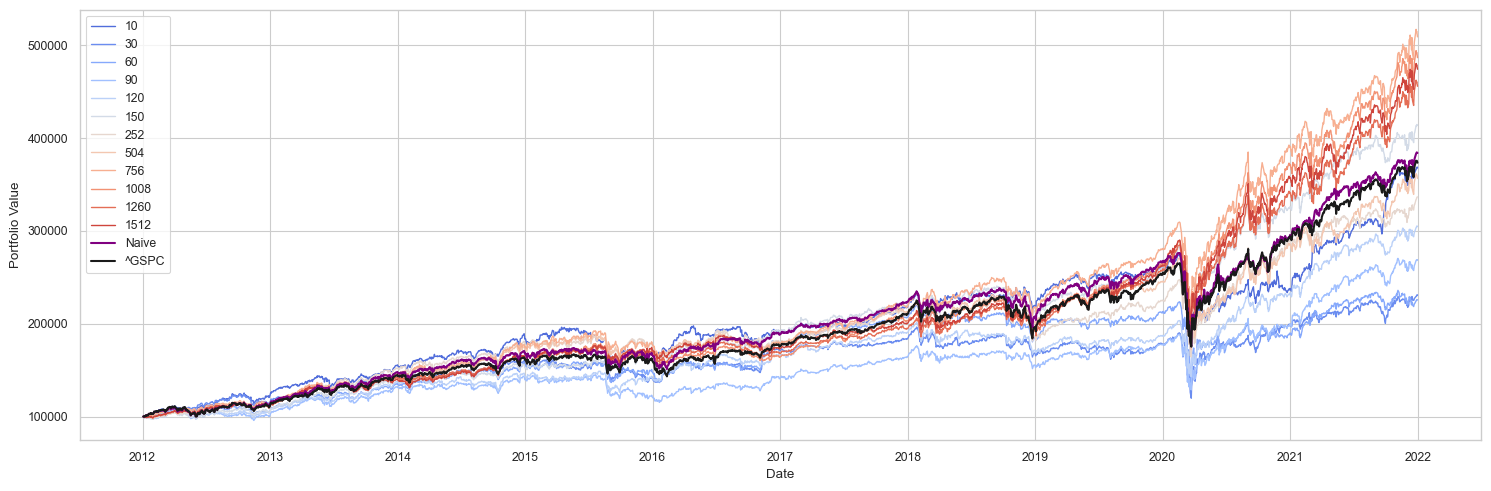

In [46]:
# eval_n_plot.plot_portfolio_val_interactive(
#     START_DATE,
#     END_DATE,
#     mvo_history_df,
#     # naive_portfolio_df=naive_portfolio_df,
#     df_ref=df_ref,
#     ref_ticker=ref_ticker,
#     initial_shares=shares_ref,
# )

eval_n_plot.plot_portfolio_val(
    START_DATE,
    END_DATE,
    mvo_history_df,
    naive_portfolio_df=naive_portfolio_df,
    df_ref=df_ref,
    ref_ticker=ref_ticker,
    initial_shares=shares_ref,
    save_dir=plt_save_dir,
    fname=f"mvo_portfolio_value_{data_src}",
)

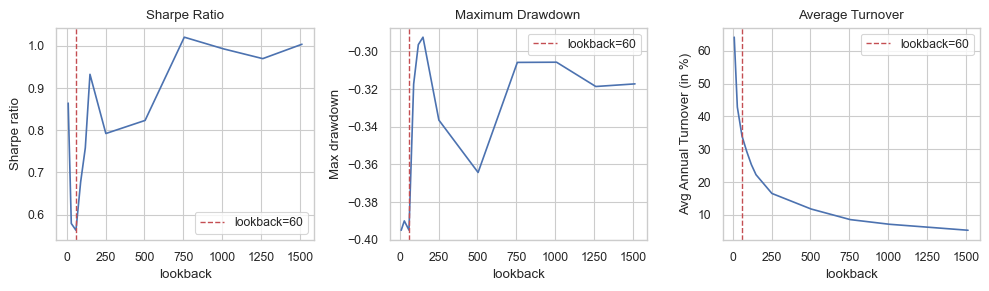

In [47]:
eval_n_plot.plot_fig2(mvo_metrics_df, plt_save_dir, f"mvo_lookback_metrics_{data_src}")

[  10   30   60   90  120  150  252  504  756 1008 1260 1512]


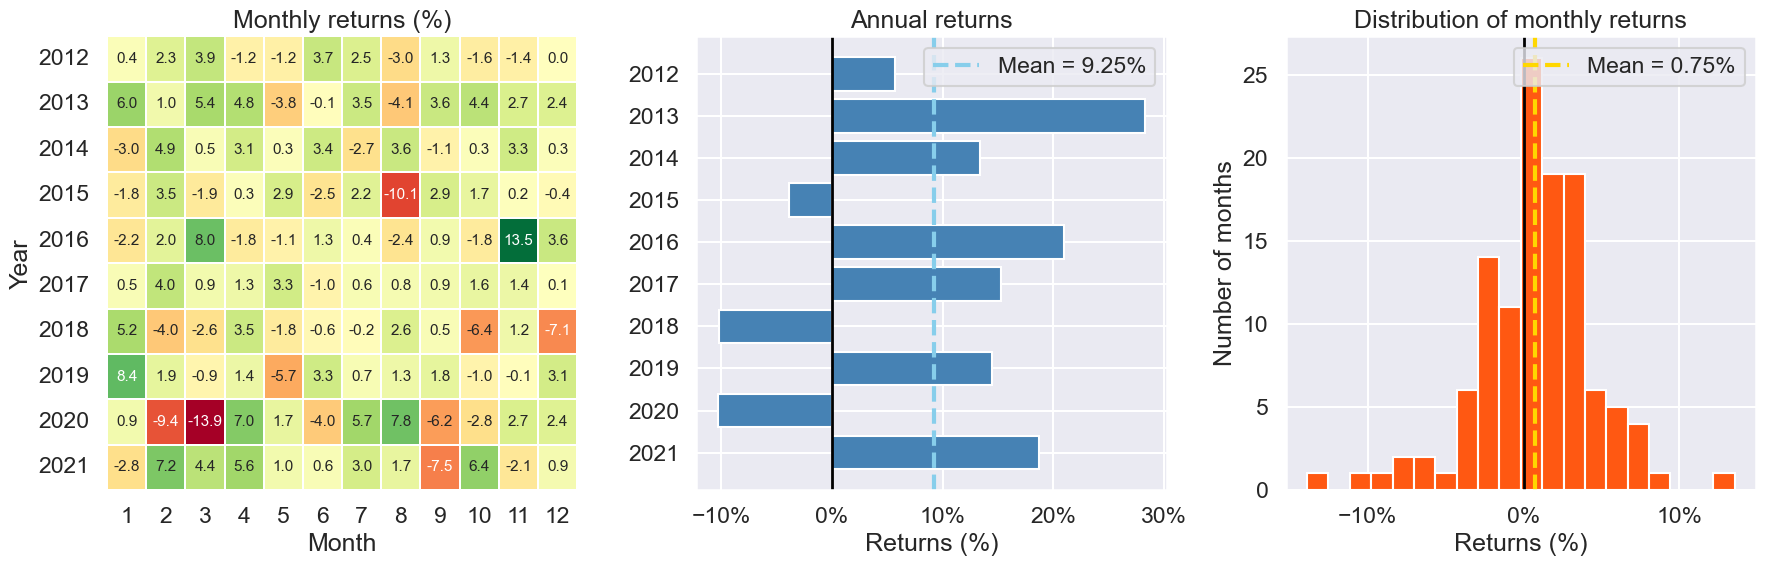

In [48]:
# Filter relevant lookback
lookback = 60
print(mvo_history_df["lookback"].unique())
focus_df = mvo_history_df[mvo_history_df["lookback"] == lookback]

monthly_pivot, annual_df = eval_n_plot.calc_monthly_annual_rets(focus_df, initial_balance)
fname = f"paper_fig4_mvo_returns_{lookback}_{data_src}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

### Buy n Hold

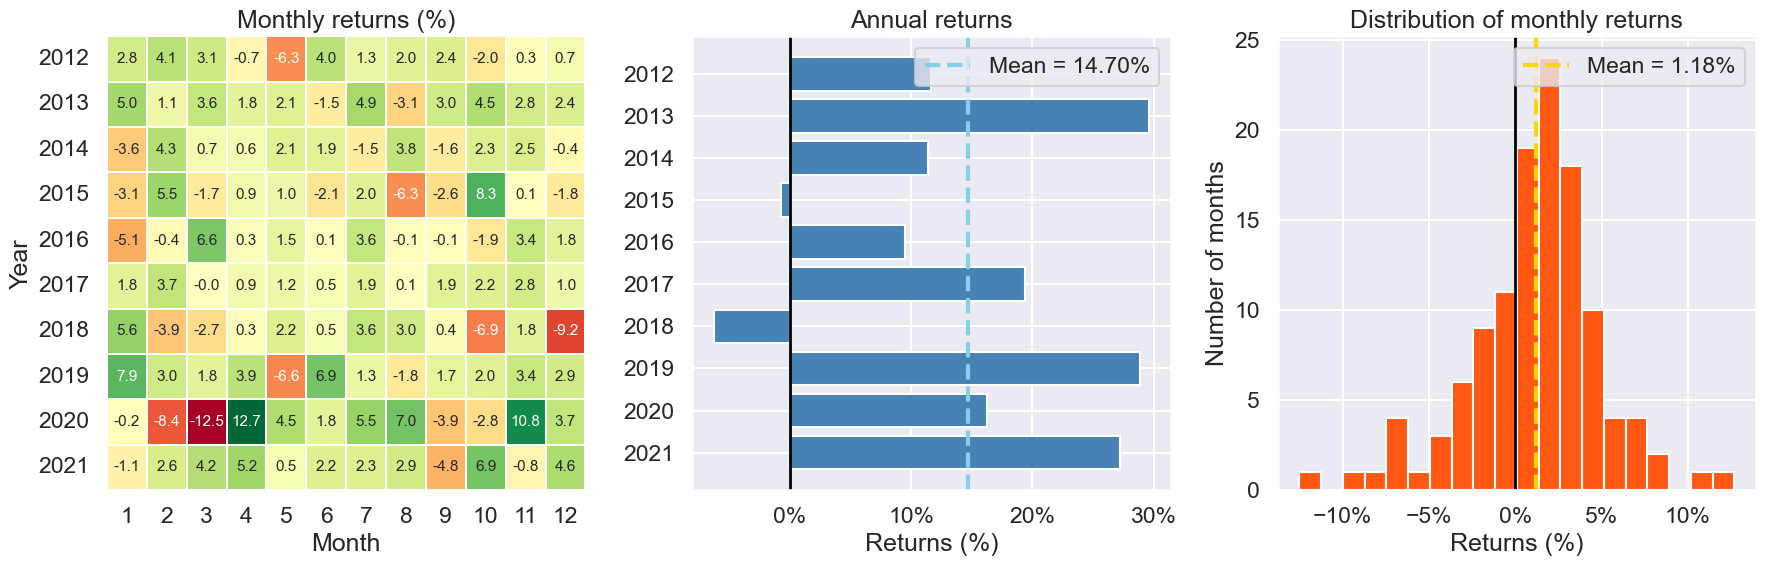

In [49]:
df_buy_n_hold = df_ref[ref_ticker].loc[(df_ref.index > START_DATE) & (df_ref.index < END_DATE)]
# make pd series df and call column : portfolio_value
df_buy_n_hold = df_buy_n_hold.to_frame(name="portfolio_value")

initial_price = df_ref[ref_ticker].loc[(df_ref.index > START_DATE)].iat[0]
monthly_pivot, annual_df = eval_n_plot.calc_monthly_annual_rets(df_buy_n_hold, initial_price)

fname = f"buy_n_hold_{data_src}"
eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

### DRL Analysis

['portfolio_10_test=2021.csv', 'portfolio_1_test=2012.csv', 'portfolio_2_test=2013.csv', 'portfolio_3_test=2014.csv', 'portfolio_4_test=2015.csv', 'portfolio_5_test=2016.csv', 'portfolio_6_test=2017.csv', 'portfolio_7_test=2018.csv', 'portfolio_8_test=2019.csv', 'portfolio_9_test=2020.csv']


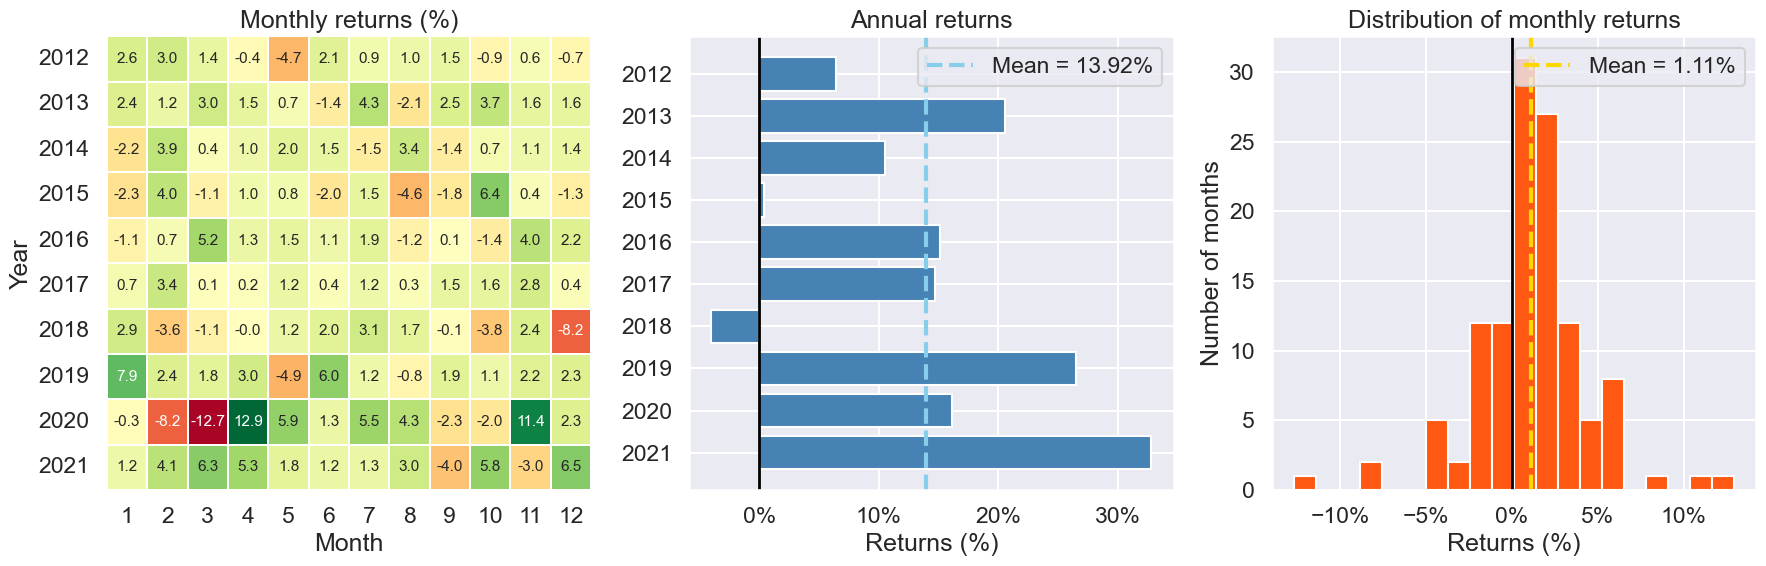

In [50]:
drl_model_name = "paper_snp"
drl_model_dir = f"../models/{drl_model_name}"

df_drl_port_paper = eval_n_plot.get_drl_portfolios(drl_model_dir)

monthly_pivot, annual_df = eval_n_plot.process_drl_portfolios(df_drl_port_paper)
fname = f"paper_fig3_drl_{drl_model_name}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

['portfolio_10_test=2021.csv', 'portfolio_1_test=2012.csv', 'portfolio_2_test=2013.csv', 'portfolio_3_test=2014.csv', 'portfolio_4_test=2015.csv', 'portfolio_5_test=2016.csv', 'portfolio_6_test=2017.csv', 'portfolio_7_test=2018.csv', 'portfolio_8_test=2019.csv', 'portfolio_9_test=2020.csv']


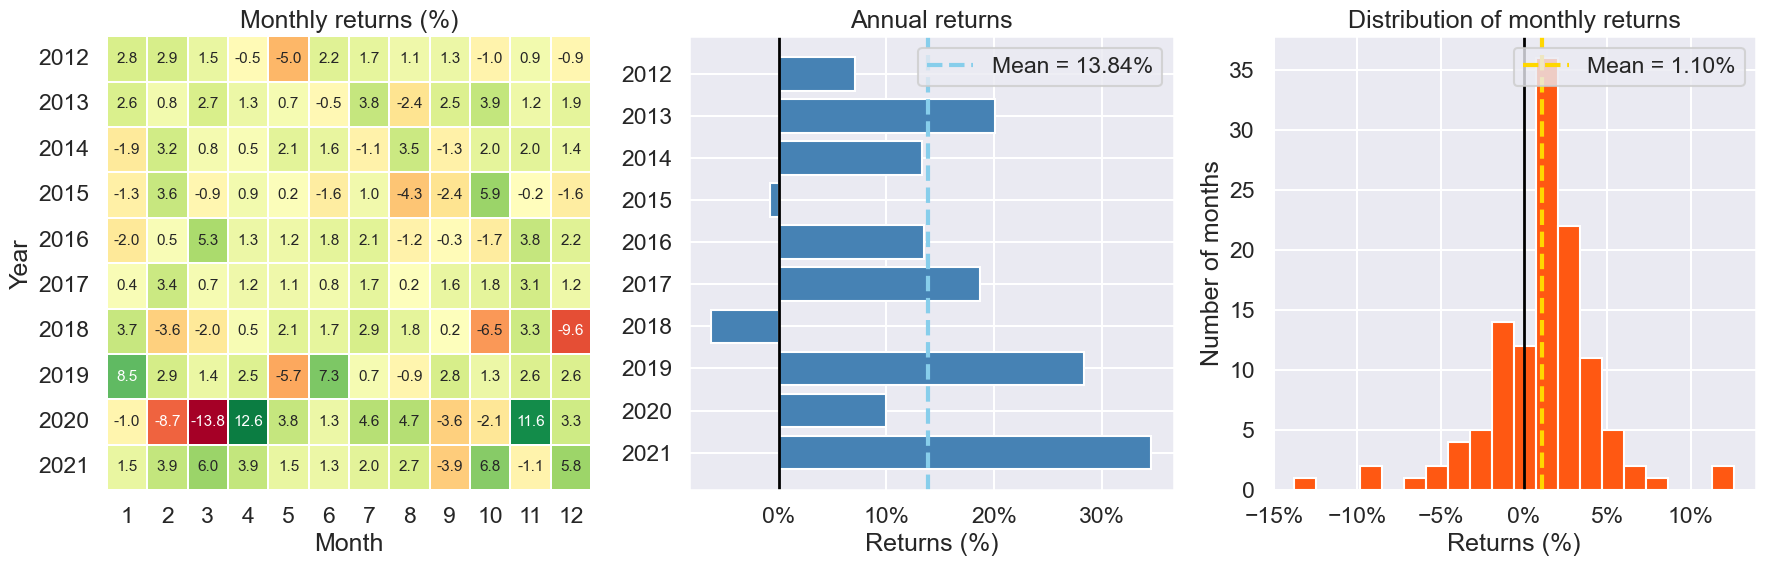

In [51]:
drl_model_name = "random_snp" # random_snp, random_msci
drl_model_dir = f"../models/{drl_model_name}"

df_drl_port_random = eval_n_plot.get_drl_portfolios(drl_model_dir)

monthly_pivot, annual_df = eval_n_plot.process_drl_portfolios(df_drl_port_random)
fname = f"paper_fig3_drl_{drl_model_name}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

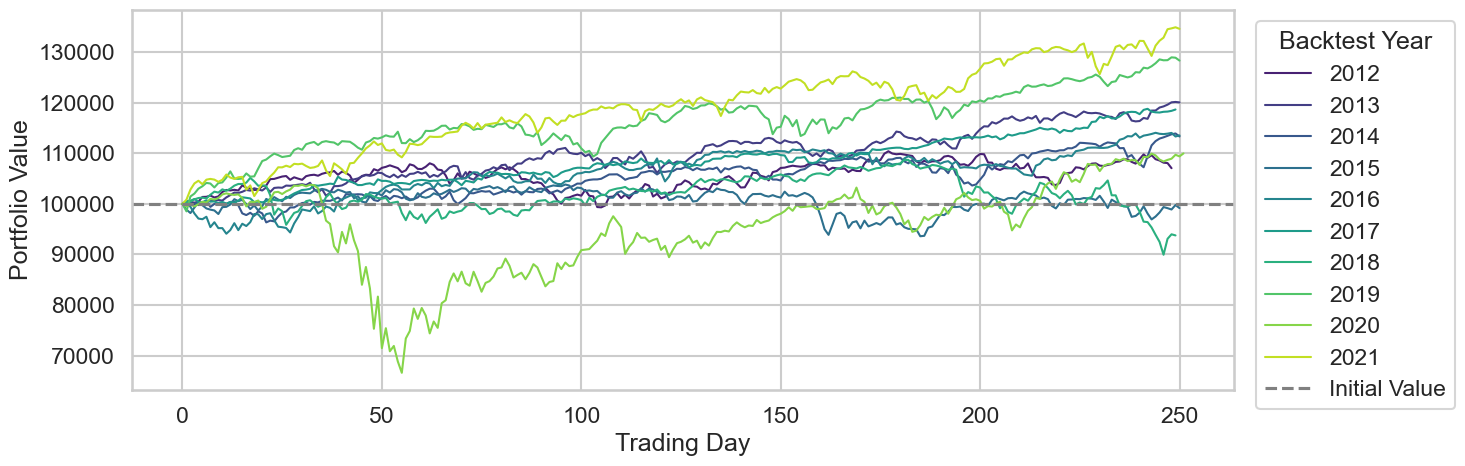

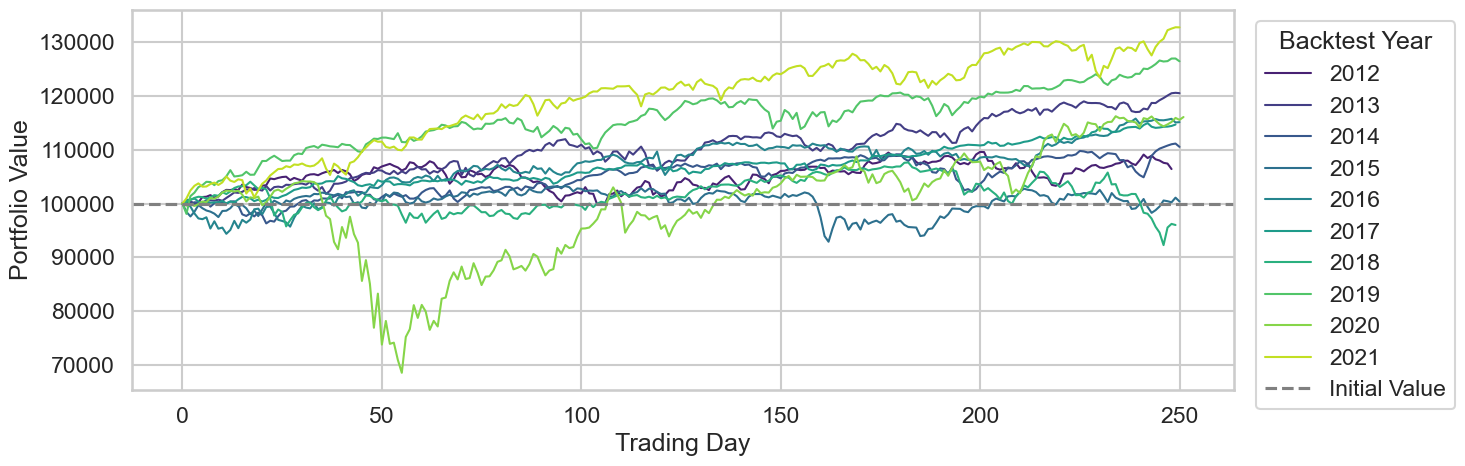

In [52]:
# eval_n_plot.plot_drl_portfolios_interactive(df_drl_port_random)
eval_n_plot.plot_drl_portfolios(df_drl_port_random, save_dir=plt_save_dir, fname="drl_portfolio_value_random")
eval_n_plot.plot_drl_portfolios(df_drl_port_paper, save_dir=plt_save_dir, fname="drl_portfolio_value_paper")

### Table of Avg Metrics

In [53]:
lookbacks = [60, 252*3]
drl_portfolios = {
    "paper": df_drl_port_paper,
    "random": df_drl_port_random,
}

df_metrics = eval_n_plot.compute_strategy_metrics(mvo_history_df, naive_portfolio_df, df_buy_n_hold, drl_portfolios, lookbacks)
ltx_code = df_metrics.to_latex(float_format="%.4f")
print(ltx_code)

\begin{tabular}{lrrrrrr}
\toprule
 & DRL_paper & DRL_random & MVO_60 & MVO_756 & Naive & Buy_n_Hold \\
\midrule
Annual Returns & 0.1405 & 0.1397 & 0.0941 & 0.1856 & 0.1508 & 0.1464 \\
Cumulative Returns & 0.1392 & 0.1384 & 0.0936 & 0.1848 & 0.1501 & 0.1455 \\
Stability & 0.8933 & 0.8903 & 0.8747 & 0.8705 & 0.8801 & 0.8749 \\
Annual Volatility & 0.1237 & 0.1276 & 0.1484 & 0.1539 & 0.1405 & 0.1469 \\
Max Drawdown & -0.3428 & -0.3580 & -0.3949 & -0.3058 & -0.3631 & -0.3392 \\
Daily VaR (95%) & -0.0122 & -0.0129 & -0.0157 & -0.0155 & -0.0138 & -0.0149 \\
Tail Ratio & 1.0052 & 0.9906 & 0.9333 & 1.0392 & 1.0413 & 1.0310 \\
Sharpe Ratio & 1.3410 & 1.3595 & 0.9364 & 1.3232 & 1.3356 & 1.2173 \\
Calmar Ratio & 2.9300 & 3.3853 & 1.8984 & 2.3495 & 2.9573 & 2.5227 \\
Omega Ratio & 1.2746 & 1.2850 & 1.1825 & 1.2698 & 1.2737 & 1.2511 \\
Sortino Ratio & 1.8423 & 1.8985 & 1.3545 & 1.8071 & 1.8436 & 1.6445 \\
Skew & -0.3828 & -0.3618 & -0.2920 & -0.3572 & -0.3732 & -0.3735 \\
Kurtosis & 2.5229 & 2.3402 

### Fig 2 - Metrics by Year